# Postprocess data

## Anomalies

In ENSO research one most often wants to work with anomaly data. Hence, data where the long time seasonality its removed. Furthermore, it is advisable for regrid all data to a common grid. Here the grid is the 2.5° x 2.5° grid from the NCAR/NCEP reananalysis.

If the data was already postprocessed and saved in the postprocessed directory, it won't be computed again if the keyword argument `new=False`. The saved files have a file name following the naming convention:

`variablename_dataset_postprocessing.extension`

This means the unprocessed data is saved to the postprocessed directory as 'sst_ERSSTv5.nc' and the anoamaly data as
'sst_ERSSTv5_anom.nc'. This naming convention makes it easy to access them later using the `ninolearn.IO.read_post.data_reader`.

In [1]:
from ninolearn.IO import read_raw
from ninolearn.postprocess.anomaly import postprocess
from ninolearn.postprocess.regrid import to2_5x2_5

# read raw data from the raw data directory
sst_ERSSTv5 = read_raw.sst_ERSSTv5()

# regrid the raw data to the 2.5° x 2.5° grid from the NCAR/NCEP reananalysis
sst_ERSSTv5_regrid = to2_5x2_5(sst_ERSSTv5)

# saves the regridded data to the postprocessed directory,
# computes the anomaly and saves the anomaly as well in the postprocessed directory
postprocess(sst_ERSSTv5_regrid, new=True)

Overwrite existing file: bilinear_89x180_73x144.nc 
 You can set reuse_weights=True to save computing time.
Process sst from ERSSTv5
--------------------------------------
save sst in post directory
Compute sst anomaly
Compute and save sst anomaly
- Read sst climatetology


## Principal component analysis (PCA)

Now, let's perform a PCA on the just computed SST anomalies (SSTA). Note, that the naming convention from the previous section now appears in the `pca.load_data()` method.

/home/paul/MEGA/Studium/UU/Master_thesis/ninolearn/ninolearn/postprocess/pca.py:156: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  m = Basemap(projection='robin', lon_0=-180, resolution='c')


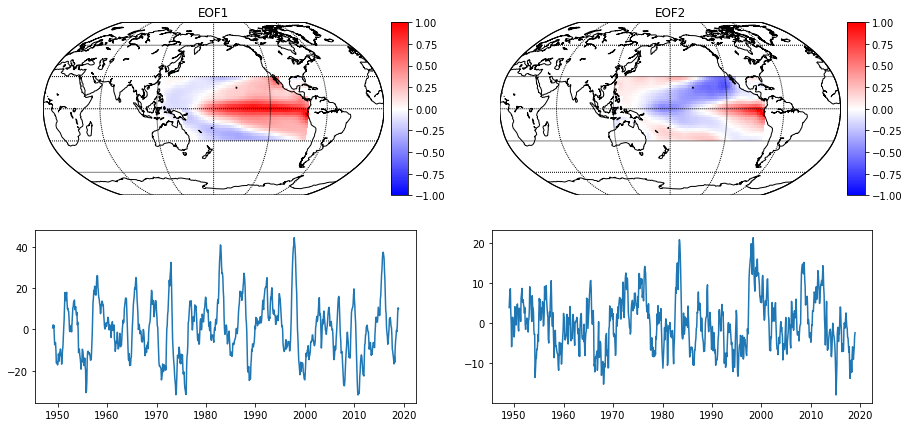

In [2]:
%matplotlib inline
from ninolearn.postprocess.pca import pca

pca_sst = pca(n_components=6)

# load the data from the post directory
pca_sst.load_data('sst', 'ERSSTv5', processed='anom', startyear=1949,
                  endyear=2018, lon_min=120, lon_max=280, lat_min=-30,
                  lat_max=30)

pca_sst.compute_pca()

# Quicklook on to the leading two EOFs
pca_sst.plot_eof()

## Evolving Climate Networks (ECNs)

The following  cell computes the ECN time series and calculates network metrics from it for the SSTA anomaly field in the equatorial Pacific (`lon_min=120, lon_max=280, lat_min=-30, lat_max=30`) between the year 2000 and 2018 (`startyear=2000, endyear=2018`). Complex networks are computed for a time window of 12 time steps (`window_size=12`) which is shifted by one time step for the next data point.

The threshold method is used in this example (also the edge density method is available). This means, connection between two nodes/grid points are established when pearson correlation greater than the threshold. 

The computation may take some time (5-20min).

In [6]:
from ninolearn.postprocess.network import networkMetricsSeries

# settings for the computation of the network metrics time series
nms = networkMetricsSeries('sst', 'ERSSTv5', processed="anom",
                           threshold=0.97, startyear=1949, endyear=2018,
                           window_size=12, lon_min=120, lon_max=280,
                           lat_min=-30, lat_max=30, verbose=2)
# compute the time series
nms.computeTimeSeries()

# save the time series again with a name following the naming convention
nms.save()

Now let us read the data from the postprocessed directory

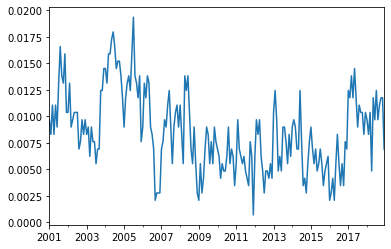

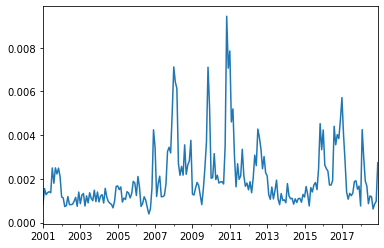

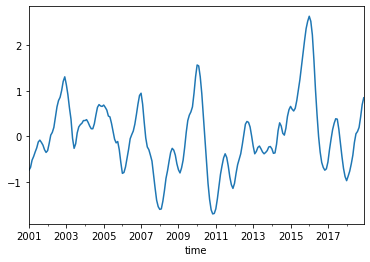

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
from ninolearn.IO.read_post import data_reader

reader = data_reader(startdate='1950-02', enddate='2018-12')

# network metrics
network_sst = reader.read_statistic('network_metrics', variable='sst', dataset='ERSSTv5', processed="anom")
c2 = network_sst['fraction_clusters_size_2']
H = network_sst['corrected_hamming_distance']

# Oceaninc nino index
oni = reader.read_csv('oni')

plt.subplots()
c2.plot()
plt.subplots()
H.plot()
plt.subplots()
oni.plot()

Is there a lead correlation of the `c2` or `H` onto the ONI? 

NOTE: Lead time is defined as the time that passed between the last observed and the first date of the target season. Hence, negative appear, e.g. if you compare the DJF season with the target season JFM, you have a lead time of -2 month (Last observed date: Feburary 28/29, First date of the target season January 1).

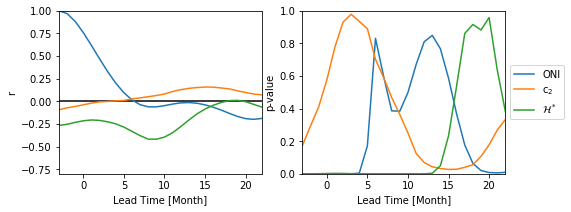

In [5]:
from ninolearn.utils import pearson_lag
import numpy as np

max_lag = 25 # month
lead_time_arr = np.arange(-3, max_lag-2)

r_oni, p_oni = pearson_lag(oni, oni, max_lags=max_lag)
r_c2, p_c2 = pearson_lag(oni, c2, max_lags=max_lag)
r_H, p_H = pearson_lag(oni, H, max_lags=max_lag)


fig, axs = plt.subplots(1, 2, figsize=(8,3))
axs[0].plot(lead_time_arr, r_oni)
axs[0].plot(lead_time_arr,r_c2)
axs[0].plot(lead_time_arr,r_H)

axs[0].set_xlim(-3, max_lag-3)
axs[0].set_ylim(-0.8, 1)
axs[0].hlines(0,-4, max_lag)
axs[0].set_ylabel('r')
axs[0].set_xlabel('Lead Time [Month]')

axs[1].plot(lead_time_arr,p_oni, label=r'ONI')
axs[1].plot(lead_time_arr,p_c2, label=r'c$_2$')
axs[1].plot(lead_time_arr,p_H, label=r'$\mathcal{H}^*$')

axs[1].set_xlim(-3, max_lag-3)
axs[1].set_ylim(0, 1.)
axs[1].set_ylabel('p-value')
axs[1].set_xlabel('Lead Time [Month]')

axs[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))

Not really!